In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import pandas as pd

all_games_df = pd.read_csv("data/all_games.csv",encoding="utf-8")
all_games_df.drop("Unnamed: 0", axis=1,inplace=True)

# Data Preparation

In [2]:
from api_helpers.game_stats_helpers import load_past_n_games
columns = ["FG_PCT", "FG3_PCT", "FTM", "OREB", "DREB", "REB", "AST"]
columns_a = [column + "_A" for column in columns]
columns_b = [column + "_B" for column in columns]

n_games_df = load_past_n_games(all_games_df=all_games_df, columns=columns)
n_games_df = n_games_df.dropna()

In [3]:
merged_data = pd.merge(
    all_games_df[columns_a + columns_b], n_games_df, left_index=True, right_index=True
)


columns_x = columns_a + columns_b
columns_x = [column + "_x" for column in columns_x]
X = merged_data[columns_x]

In [4]:
columns_y = columns_a + columns_b
columns_y = [column + "_y" for column in columns_y]
y = merged_data[columns_y]

## Test Train Split

In [1]:
from sklearn.model_selection import train_test_split
import numpy as np


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

NameError: name 'X' is not defined

# Preloading Neural Network

In [6]:
# Predicting Game Outcome
from tensorflow.keras.models import model_from_json

# load json and create model
json_file = open("tuned_nn.json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("tuned.weights.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

2024-07-22 14:21:54.040622: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-22 14:21:54.052357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 14:21:54.062397: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 14:21:54.065192: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-22 14:21:54.072864: I tensorflow/core/platform/cpu_feature_guar

Loaded model from disk


2024-07-22 14:21:54.834515: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-07-22 14:21:54.834537: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:135] retrieving CUDA diagnostic information for host: rohanbendapudi-Precision-3581
2024-07-22 14:21:54.834540: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:142] hostname: rohanbendapudi-Precision-3581
2024-07-22 14:21:54.834651: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:166] libcuda reported version is: 535.183.1
2024-07-22 14:21:54.834659: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] kernel reported version is: 535.183.1
2024-07-22 14:21:54.834661: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:249] kernel version seems to match DSO: 535.183.1


In [7]:
y_final_true = all_games_df["WL_A"].loc[y_test.index].to_frame()
y_final_true.replace("W",1,inplace=True)
y_final_true.replace("L",0,inplace=True)
y_final_true.replace(" ",0,inplace=True)
y_final_true = list(y_final_true["WL_A"])

/tmp/ipykernel_446751/583459057.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_final_true.replace("L",0,inplace=True)


# Building and Testing XGBoost

In [8]:
%skip
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

UsageError: Line magic function `%skip` not found.


In [52]:
%skip
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)

UsageError: Line magic function `%skip` not found.


## Hyperparameter Tuning

In [53]:
%skip
from hyperopt import tpe, hp, STATUS_OK
from sklearn.metrics import r2_score, mean_squared_error
import hyperopt
import sklearn
import optuna
from xgboost import XGBRegressor

def objective(trial):
    # param = {
    #     "device": "cuda",
    #     "gamma": trial.suggest_categorical("gamma", [18, 19, 20, 21, 22, 23, 24, 25]),
    #     "learning_rate": trial.suggest_categorical(
    #         "learning_rate", [0.008, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02]
    #     ),
    #     "colsample_bytree": trial.suggest_categorical(
    #         "colsample_bytree", [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    #     ),
    #     "colsample_bynode": trial.suggest_categorical(
    #         "colsample_bynode", [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    #     ),
    #     "n_estimators": trial.suggest_int("n_estimators", 30, 200),
    #     "max_depth": trial.suggest_categorical("max_depth", [3, 4, 5, 6, 7]),
    #     "subsample": trial.suggest_categorical("subsample", [0.5, 0.6, 0.7, 0.8, 1.0]),
    #     "random_state": 42,
    # }

    param = {
        "device": "cuda",
        "n_estimators": 100,
        "max_depth": 8,
        "eta": 0.1,
        "subsample": 0.4,
        "colsample_bytree": 0.9,
        "random_state": 42,
        "gamma": trial.suggest_categorical("gamma", [0, 1, 2, 3, 4, 5]),
        "learning_rate": trial.suggest_categorical(
            "learning_rate", [0.1, 0.2, 0.3, 0.4, 0.5]
        ),
        "colsample_bynode": trial.suggest_categorical(
            "colsample_bynode", [0.3, 0.4, 0.5, 0.6, 0.7]
        ),
    }

    model = XGBRegressor(**param)

    model.fit(X_train, y_train, verbose=False)

    y_pred = model.predict(X_test)

    scaler = joblib.load("scaler.bin")

    y_final_pred = loaded_model.predict(scaler.transform(y_pred))
    y_pred_true = np.argmax(y_final_pred, axis=1)

    y_pred_true = y_pred_true.tolist()

    accuracy = accuracy_score(y_final_true, list(y_pred_true))

    return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, timeout=600)

UsageError: Line magic function `%skip` not found.


In [54]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  3
Best trial:
  Value: 0.6014581952466622
  Params: 


/home/rohanbendapudi/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:22:08] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
<class 'int'>
True
Best Neural Network classification report:
              precision    recall  f1-score   support

           0       0.78      0.24      0.37      4206
           1       0.66      0.96      0.78      6355

    accuracy                           0.67     10561
   macro avg       0.72      0.60      0.57     10561
weighted avg       0.71      0.67      0.62     10561



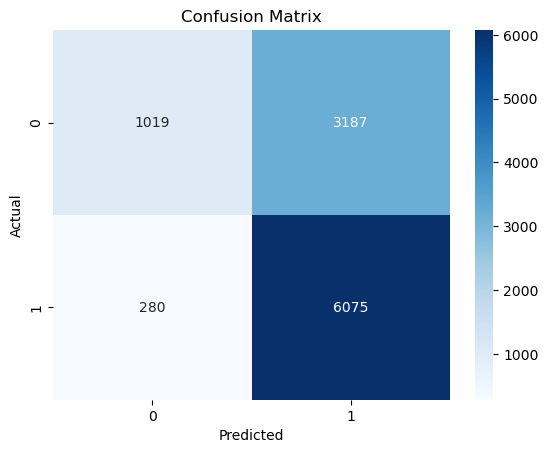

In [10]:

from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# create an xgboost regression model

param = {
    "device": "cuda",
    "n_estimators": 100,
    "max_depth": 8,
    "eta": 0.1,
    "subsample": 0.4,
    "colsample_bytree": 0.9,
    "random_state": 42,
    "gamma": 0,
    "learning_rate":0.1,
    "colsample_bynode": 0.6,
}

model = XGBRegressor(**param)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

scaler = joblib.load("scaler.bin")

y_final_pred = loaded_model.predict(scaler.transform(y_pred))
y_pred_true = np.argmax(y_final_pred, axis=1)

y_pred_true = y_pred_true.tolist()
print(type(y_pred_true[0]))

print(all(isinstance(x, int) for x in y_final_true))

# Evaluate the model
print('Best Neural Network classification report:')
print(classification_report(y_final_true, list(y_pred_true)))

# Confusion matrix
conf_matrix_nn = confusion_matrix(y_final_true, list(y_pred_true))
sns.heatmap(conf_matrix_nn, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [56]:
import shap
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation

In [ ]:
X_idx = 0
shap_value_single = explainer.shap_values(X=X.iloc[X_idx : X_idx + 1, :])

In [ ]:
import ipywidgets as widgets

# Create the list of all labels for the drop down list
list_of_labels = y.columns.to_list()

# Create a list of tuples so that the index of the label is what is returned
tuple_of_labels = list(zip(list_of_labels, range(len(list_of_labels))))

# Create a widget for the labels and then display the widget
current_label = widgets.Dropdown(options=tuple_of_labels, value=0, description="Select Label:")

# Display the dropdown list (Note: access index value with 'current_label.value')
current_label

Dropdown(description='Select Label:', options=(('FG_PCT_A_y', 0), ('FG3_PCT_A_y', 1), ('FTM_A_y', 2), ('OREB_A…

In [ ]:
from IPython.display import HTML
X_idx = 0
# print the JS visualization code to the notebook
shap.initjs()

print(f"Current label Shown: {list_of_labels[current_label.value]}")



force_plot = shap.force_plot(
    base_value=explainer.expected_value[current_label.value],
    shap_values=shap_value_single[current_label.value],
    features=X.columns,
)

HTML(f"<div style='background-color:white;'>{shap.getjs() + force_plot.html()}</div>")

Current label Shown: FG_PCT_A_y


In [ ]:
shap_values = explainer.shap_values(X=X.iloc[0:50, :])

Current Label Shown: FG_PCT_A_y



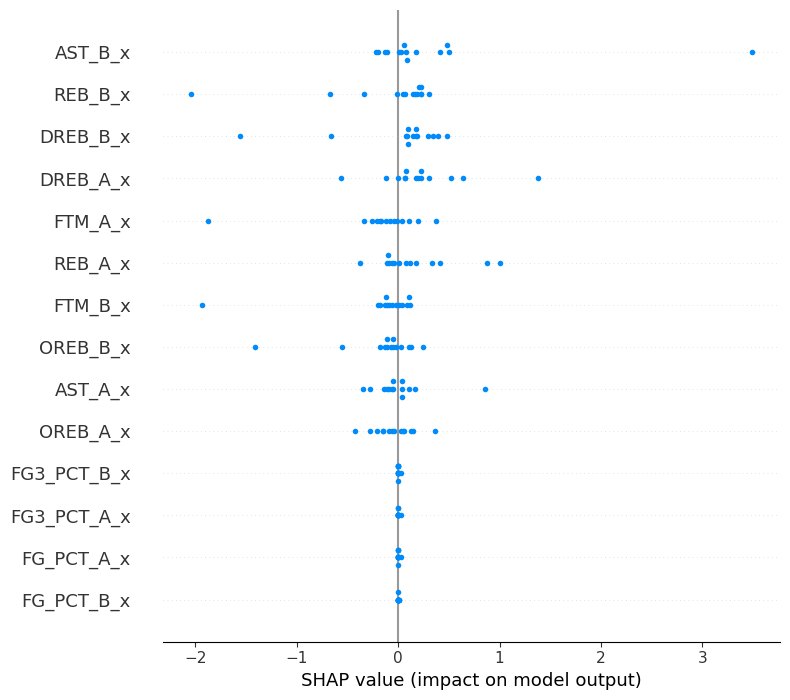

In [ ]:
# print the JS visualization code to the notebook
shap.initjs()

print(f"Current Label Shown: {list_of_labels[current_label.value]}\n")

shap.summary_plot(shap_values=shap_values[current_label.value], features=X.columns)

Current Label Shown: FG_PCT_A_y

